<div style="background-color: #b3cde0; padding: 20px; border-radius: 10px; text-align: center; margin: 20px 0;">
    <h1 style="font-size: 3em; color: #333;">EDA + Course Engagement Prediction</h1>
</div>

---

## 1. Exploratory Data Analysis (EDA)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import PowerTransformer

In [2]:
df = pd.read_csv("/kaggle/input/predict-online-course-engagement-dataset/online_course_engagement_data.csv")

### Initial Data Exploration

In [3]:
df.head()

,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
0,5618,Health,29.979719,17,3,50.365656,20.860773,1,0
1,4326,Arts,27.802640,1,5,62.615970,65.632415,1,0
2,5849,Arts,86.820485,14,2,78.458962,63.812007,1,1
3,4992,Science,35.038427,17,10,59.198853,95.433162,0,1
4,3866,Programming,92.490647,16,0,98.428285,18.102478,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 9000 non-null   int64  
 1   CourseCategory         9000 non-null   object 
 2   TimeSpentOnCourse      9000 non-null   float64
 3   NumberOfVideosWatched  9000 non-null   int64  
 4   NumberOfQuizzesTaken   9000 non-null   int64  
 5   QuizScores             9000 non-null   float64
 6   CompletionRate         9000 non-null   float64
 7   DeviceType             9000 non-null   int64  
 8   CourseCompletion       9000 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 632.9+ KB


In [5]:
df.describe()

,UserID,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,4498.894556,50.163822,10.024667,5.090556,74.706028,50.340146,0.500667,0.396444
std,2596.849433,28.491750,6.029878,3.157762,14.378383,28.950977,0.500027,0.489186
min,1.000000,1.005230,0.000000,0.000000,50.005119,0.009327,0.000000,0.000000
25%,2251.750000,25.440548,5.000000,2.000000,62.283451,25.653614,0.000000,0.000000
50%,4483.500000,49.818417,10.000000,5.000000,74.743294,50.264124,1.000000,0.000000
75%,6751.250000,75.069924,15.000000,8.000000,87.022663,75.572493,1.000000,1.000000
max,9000.000000,99.992558,20.000000,10.000000,99.994984,99.979711,1.000000,1.000000


In [6]:
df.isnull().sum()

UserID                   0
CourseCategory           0
TimeSpentOnCourse        0
NumberOfVideosWatched    0
NumberOfQuizzesTaken     0
QuizScores               0
CompletionRate           0
DeviceType               0
CourseCompletion         0
dtype: int64

In [7]:
df.duplicated().sum()

877

In [8]:
# Remove duplicates
df = df.drop_duplicates()

### Outlier Detection and Removal

In [9]:
# Remove outliers using Z-score
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]

### Normalization Check and Transformation

In [10]:
# Apply Shapiro-Wilk test and normalize if needed
for column in df.select_dtypes(include=[np.number]).columns:
    stat, p = stats.shapiro(df[column])
    if p < 0.05:
        # Applying PowerTransformer for normalization
        pt = PowerTransformer()
        df[[column]] = pt.fit_transform(df[[column]])

/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/conda/lib/python3.10/site-packages/scipy/stats/_moresta

### Encoding Categorical Variables

In [11]:
# Encoding categorical variables
df = pd.get_dummies(df, columns=['CourseCategory', 'DeviceType'], drop_first=True)

In [12]:
# Ensure target variable is binary categorical
df['CourseCompletion'] = df['CourseCompletion'].astype('int')

In [13]:
# Feature Engineering: Creating new features
df['VideosPerQuiz'] = df['NumberOfVideosWatched'] / (df['NumberOfQuizzesTaken'] + 1)  
df['TimePerVideo'] = df['TimeSpentOnCourse'] / (df['NumberOfVideosWatched'] + 1)

In [14]:
df.columns

Index(['UserID', 'TimeSpentOnCourse', 'NumberOfVideosWatched',
       'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate',
       'CourseCompletion', 'CourseCategory_Business', 'CourseCategory_Health',
       'CourseCategory_Programming', 'CourseCategory_Science',
       'DeviceType_0.9991386204025082', 'VideosPerQuiz', 'TimePerVideo'],
      dtype='object')

<Figure size 1500x1000 with 0 Axes>

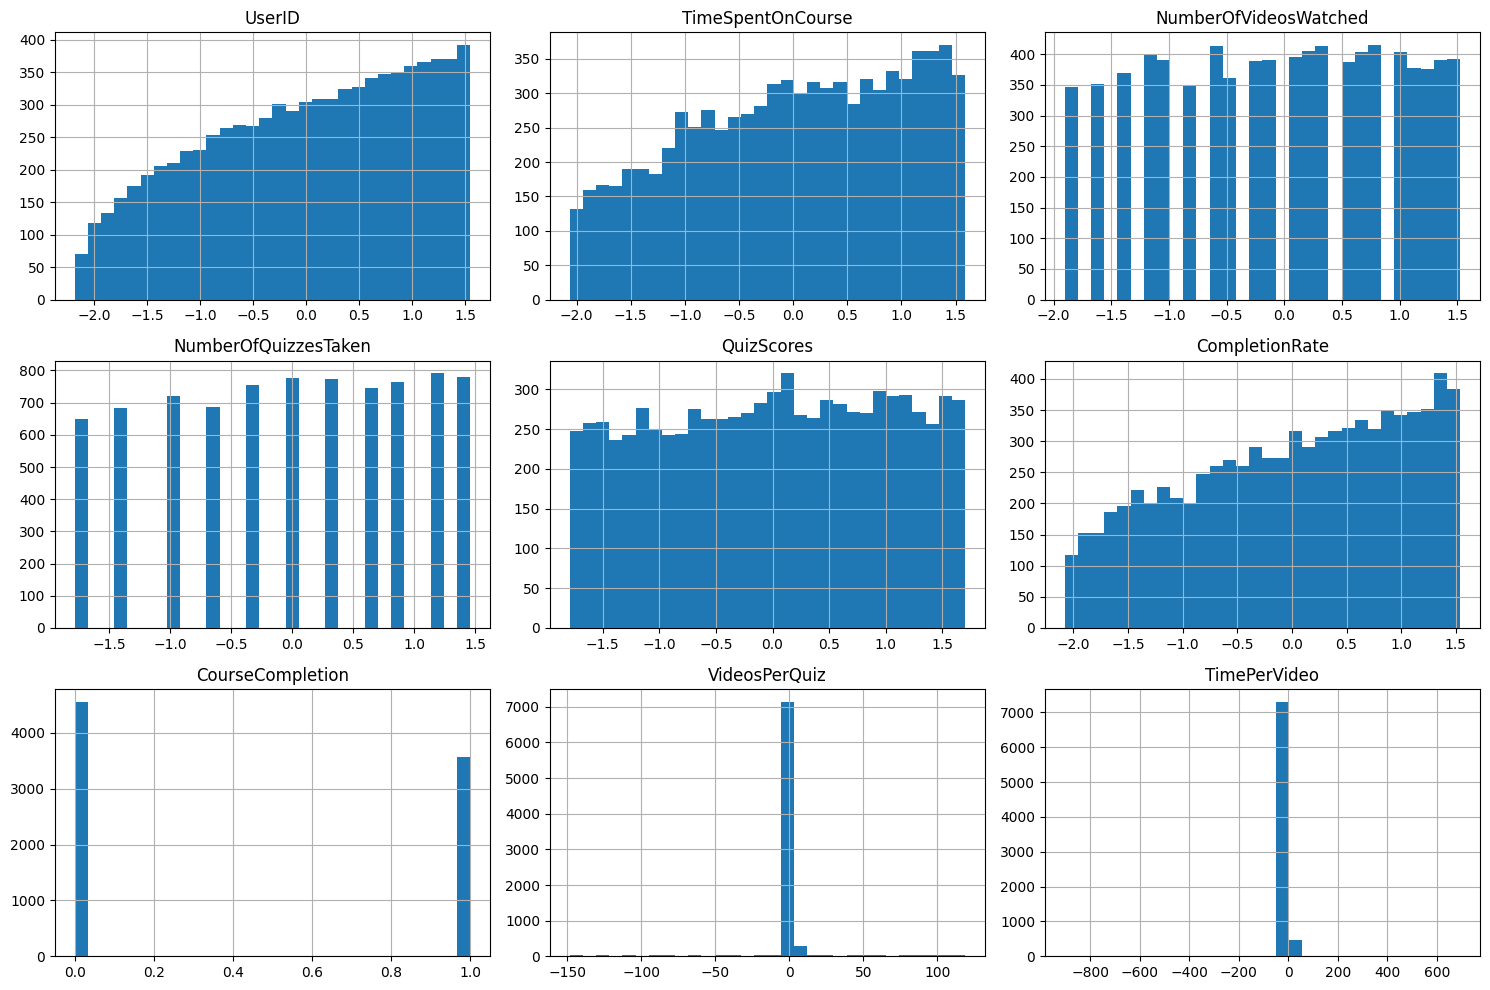

In [15]:
# Plot distribution of numeric features
plt.figure(figsize=(15, 10))
df.hist(bins=30, figsize=(15, 10), layout=(3, 3))
plt.tight_layout()
plt.show()

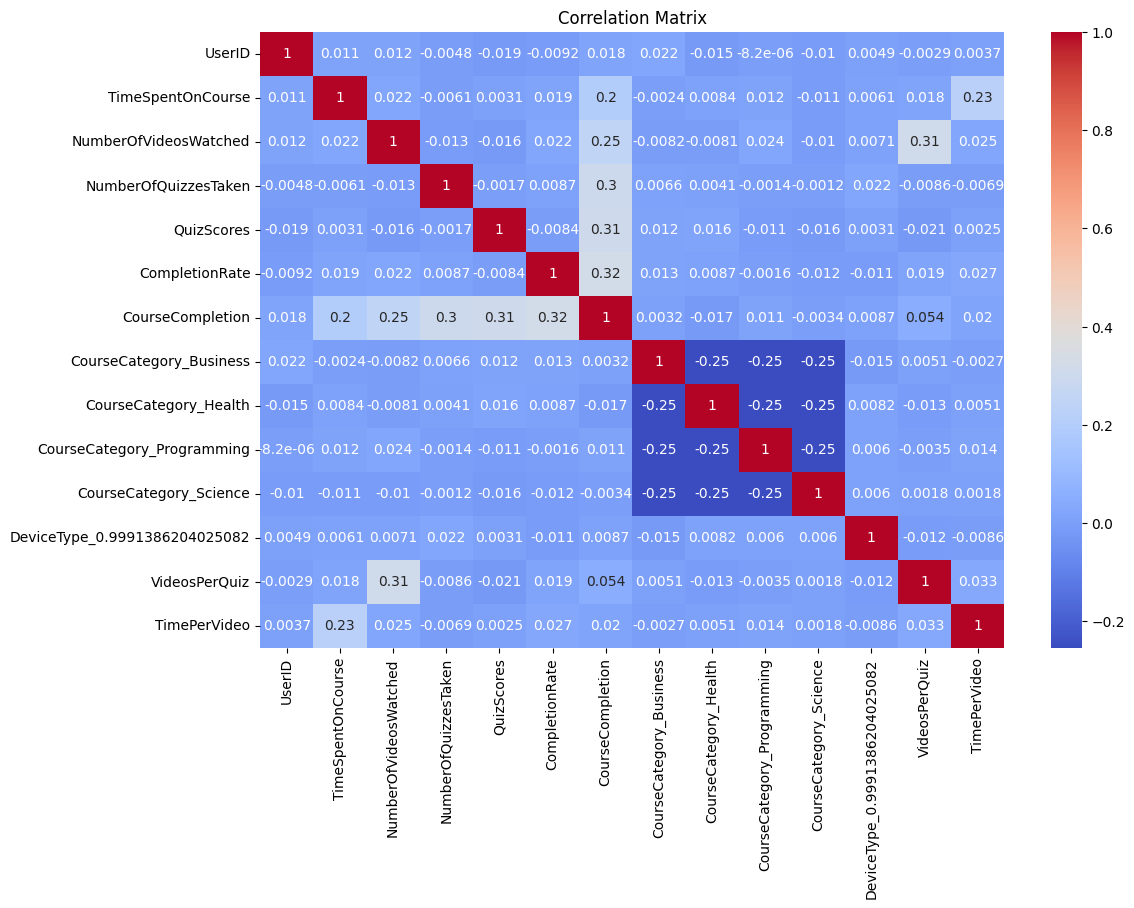

In [16]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

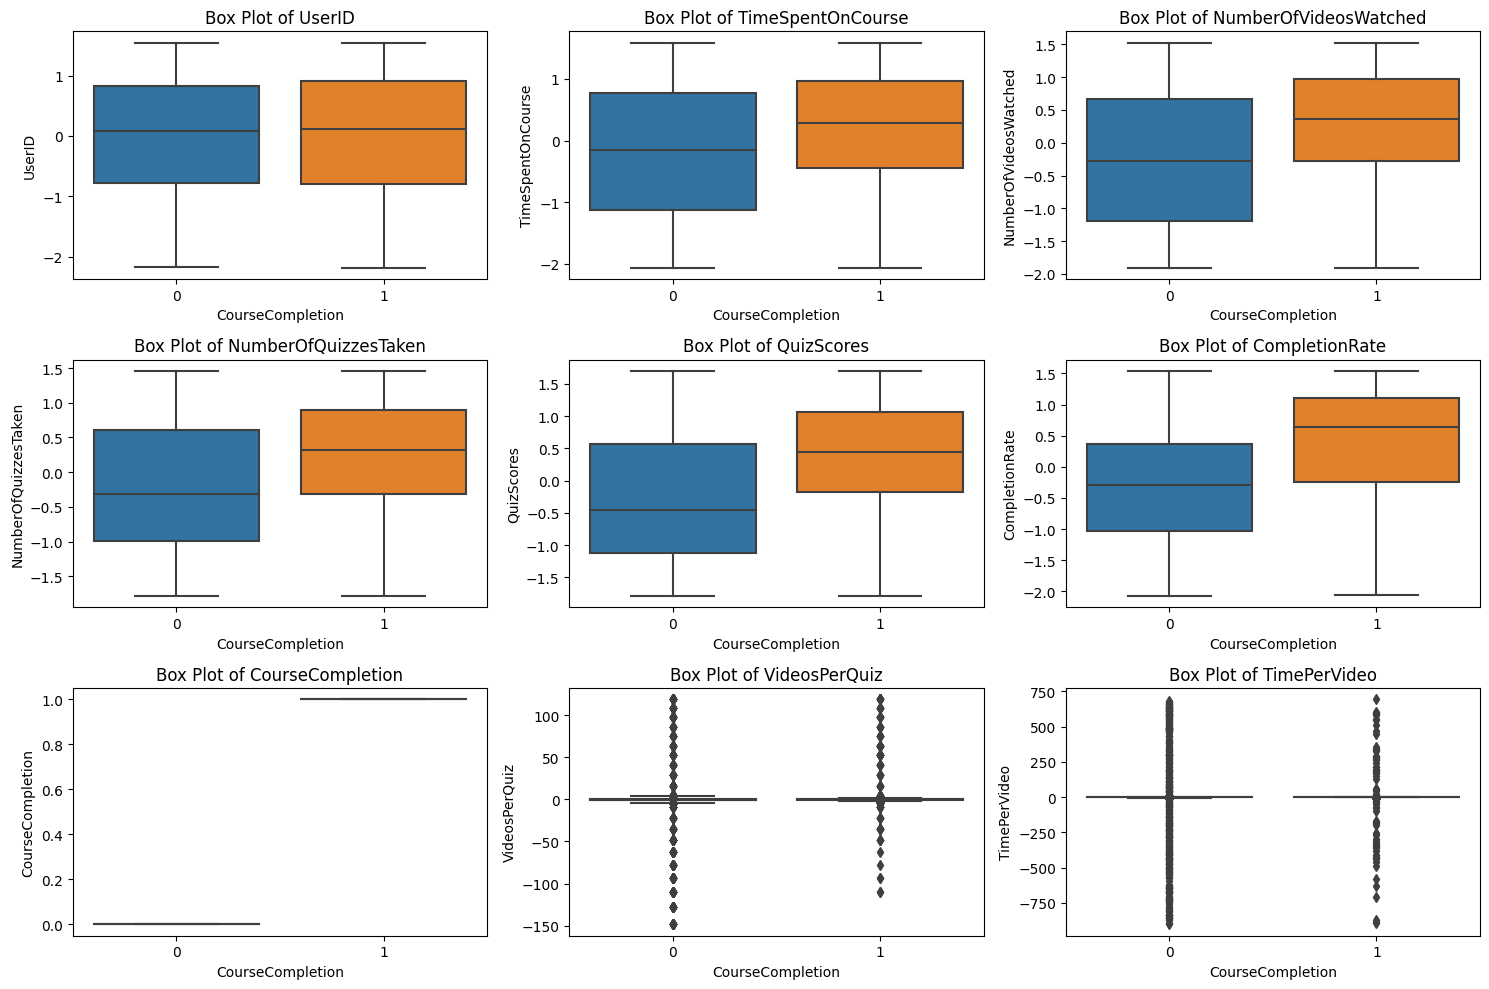

In [17]:
# Box plots to check distribution and outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.select_dtypes(include=[np.number]).columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='CourseCompletion', y=column, data=df)
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

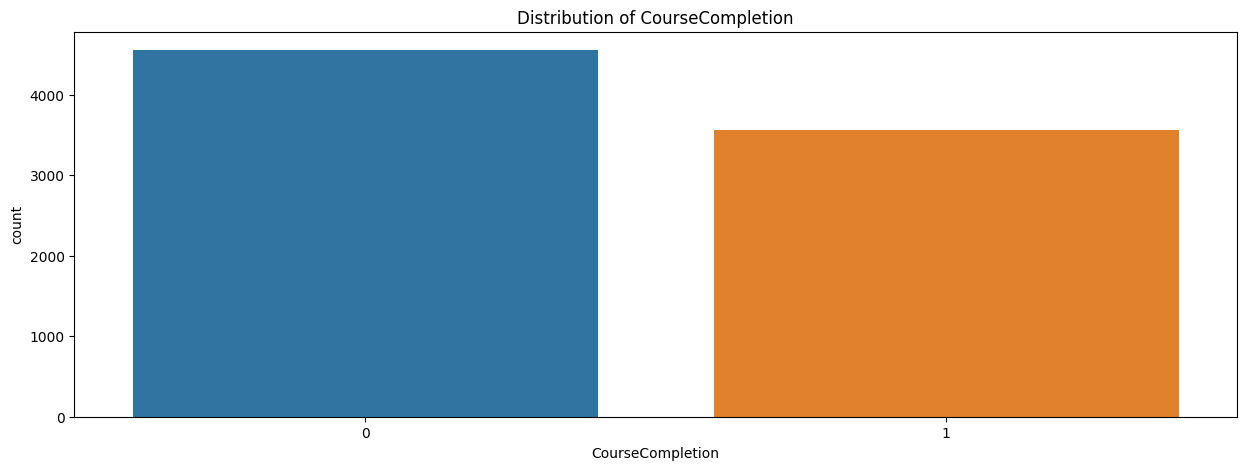

In [18]:
# Bar plots for categorical variables
plt.figure(figsize=(15, 5))
sns.countplot(x='CourseCompletion', data=df)
plt.title('Distribution of CourseCompletion')
plt.show()

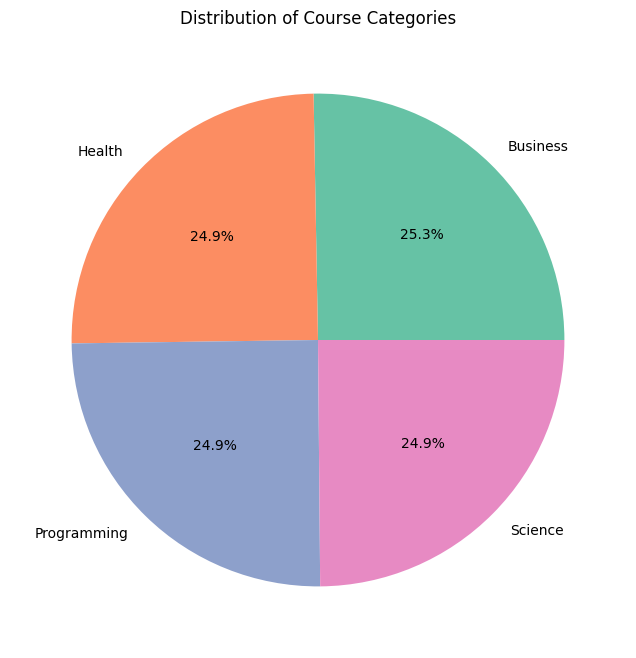

In [19]:
# Dynamic pie chart for course categories
course_category_columns = [col for col in df.columns if 'CourseCategory_' in col]
course_category_counts = df[course_category_columns].sum()
course_category_counts.index = [col.split('_')[1] for col in course_category_columns]
plt.figure(figsize=(8, 8))
course_category_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Distribution of Course Categories')
plt.ylabel('')
plt.show()

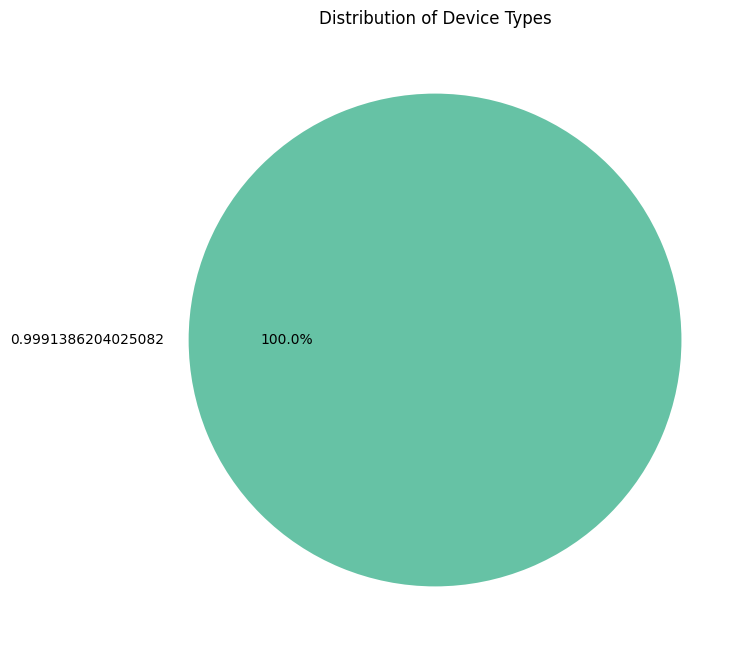

In [20]:
# Dynamic pie chart for device types
device_type_columns = [col for col in df.columns if 'DeviceType_' in col]
device_type_counts = df[device_type_columns].sum()
device_type_counts.index = [col.split('_')[1] for col in device_type_columns]
plt.figure(figsize=(8, 8))
device_type_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Distribution of Device Types')
plt.ylabel('')
plt.show()

## 2. Splitting the Data

In [21]:
# Splitting the data
X = df.drop('CourseCompletion', axis=1)
y = df['CourseCompletion']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Hyperparameter Tuning with GridSearchCV

In [23]:

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 3, 4]
}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [24]:
# Best model from GridSearchCV
best_model = grid_search.best_estimator_
print(f'Best parameters found: {grid_search.best_params_}')

Best parameters found: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 300, 'subsample': 0.8}


## 4. Model Evaluation

In [25]:
# Evaluating the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       894
           1       0.95      0.96      0.96       731

    accuracy                           0.96      1625
   macro avg       0.96      0.96      0.96      1625
weighted avg       0.96      0.96      0.96      1625

Confusion Matrix:
[[859  35]
 [ 30 701]]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


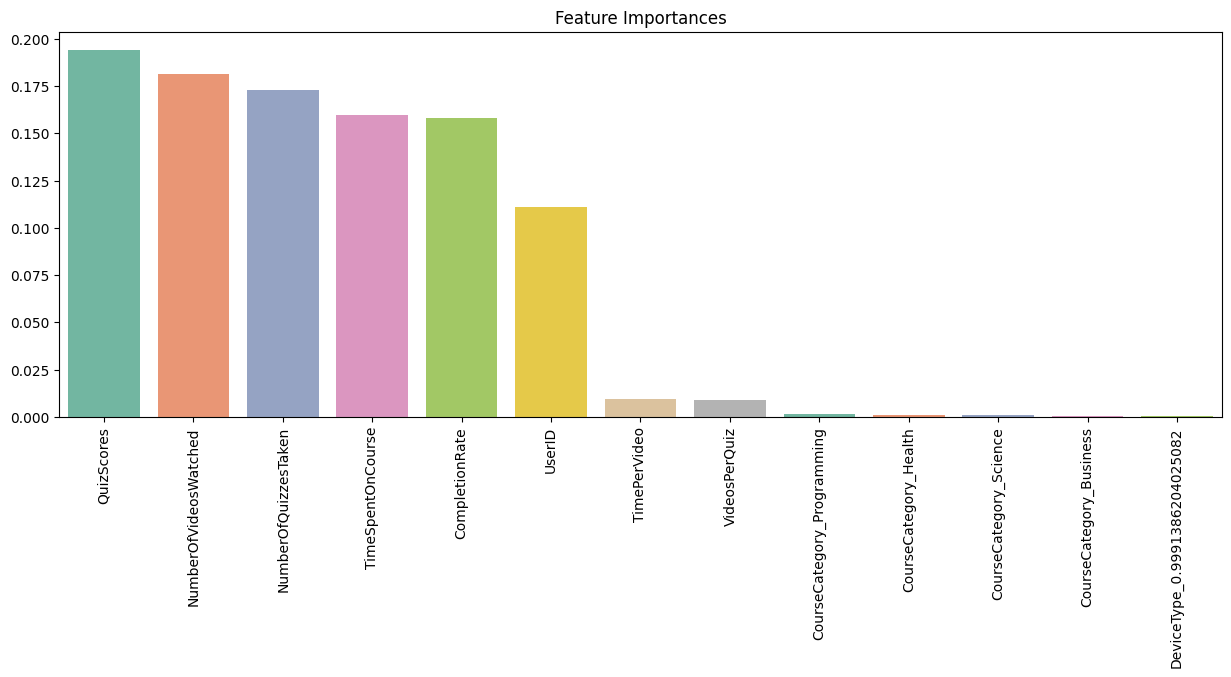

In [26]:
# Plotting feature importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15, 5))
sns.barplot(x=[X.columns[i] for i in indices], y=importances[indices], palette='Set2')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

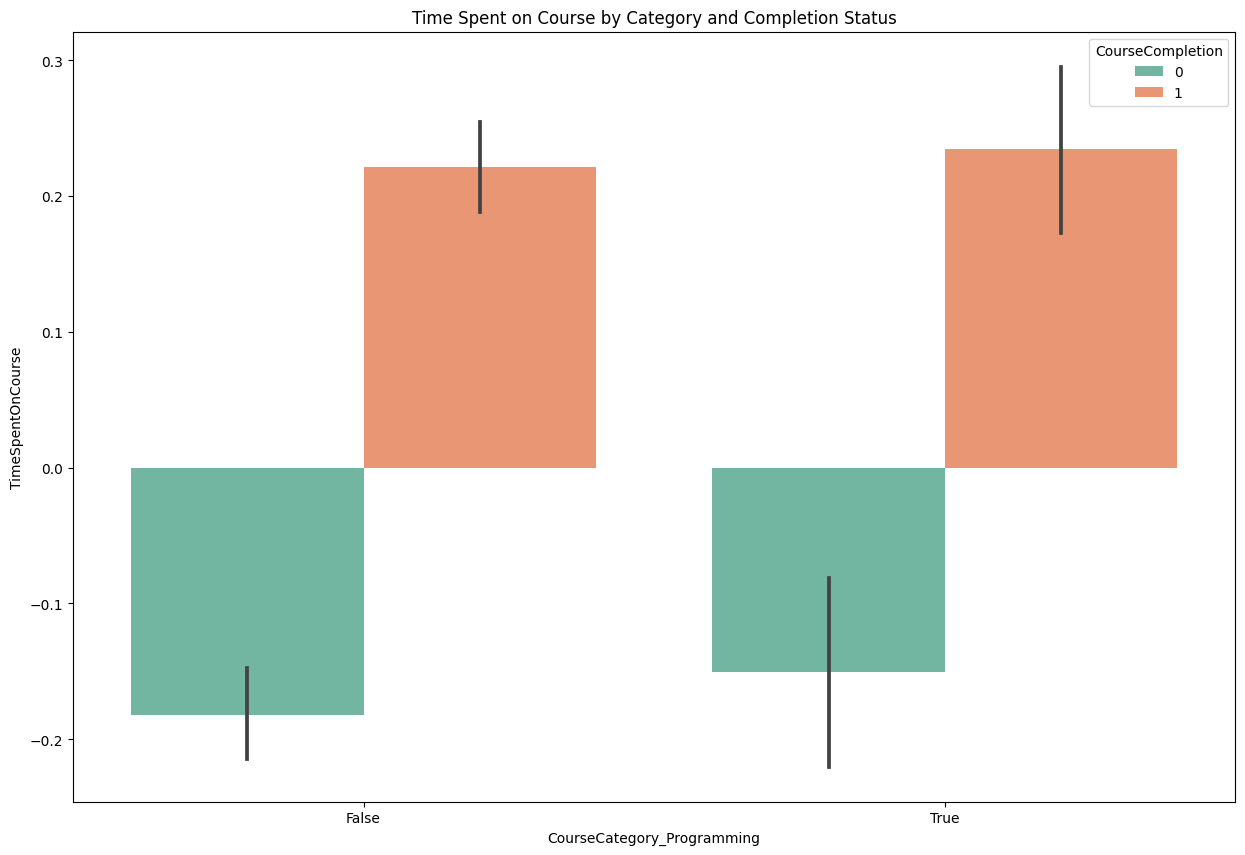

In [27]:
# Comparing performance of different categories
plt.figure(figsize=(15, 10))
sns.barplot(x='CourseCategory_Programming', y='TimeSpentOnCourse', hue='CourseCompletion', data=df, palette='Set2')
plt.title('Time Spent on Course by Category and Completion Status')
plt.show()

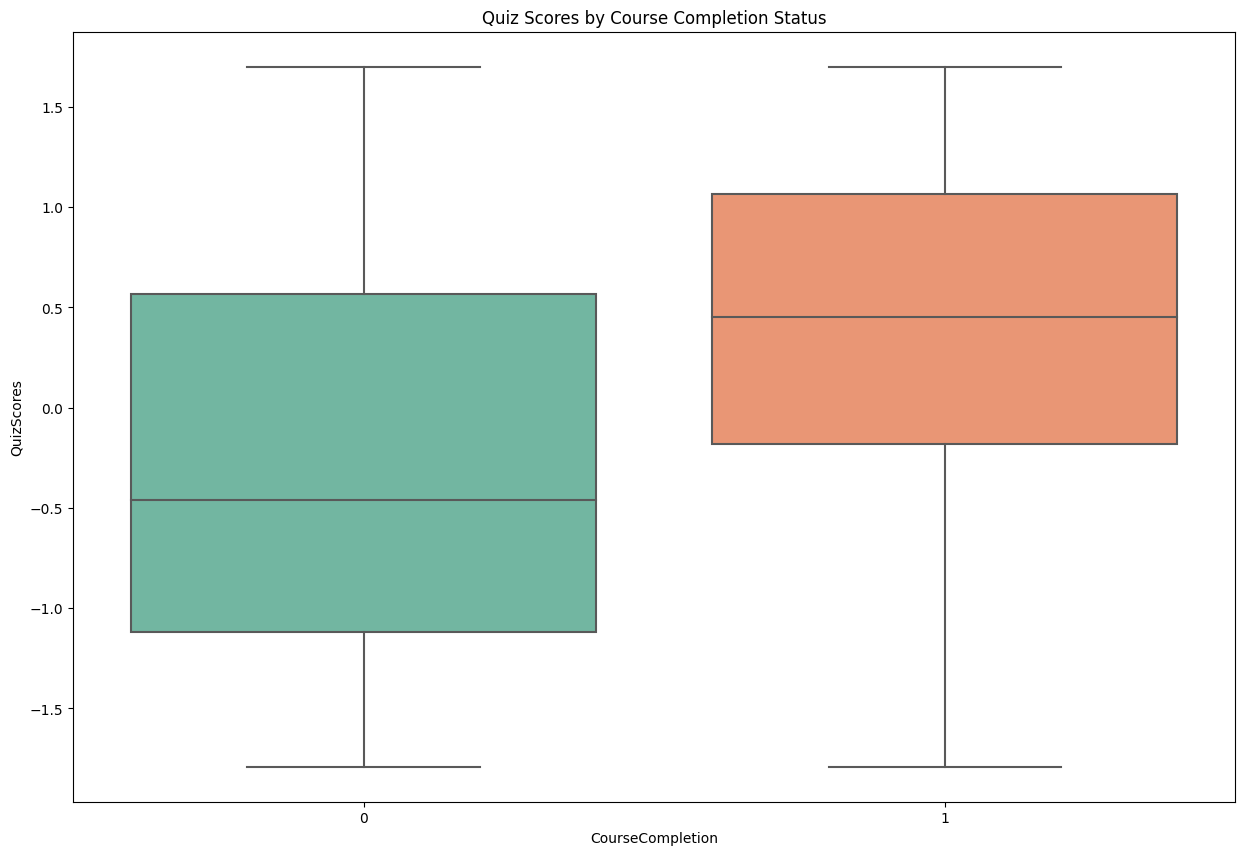

In [28]:
# Comparing quiz scores with course completion
plt.figure(figsize=(15, 10))
sns.boxplot(x='CourseCompletion', y='QuizScores', data=df, palette='Set2')
plt.title('Quiz Scores by Course Completion Status')
plt.show()